# Modélisation Prédictive et Analyse Comparative

Ce notebook constitue la première phase de modélisation de notre étude sur les températures parisiennes. Il s'appuie directement sur les diagnostics structurels établis dans le **Notebook 3 (Analyse des Séries Temporelles)**.

### Objectifs de Recherche
Notre objectif est de construire des modèles stochastiques capables de prévoir la température horaire ($T_{2m}$). Nous adoptons une approche de complexité croissante pour valider statistiquement l'apport de chaque modèle :
1.  **Modélisation Baseline :** Établir un seuil de performance minimal via une approche naïve.
2.  **Modélisation Paramétrique (SARIMA) :** Implémenter un modèle linéaire capturant la structure auto-corrélée identifiée précédemment.
3.  **Protocole d'Évaluation :** Comparer les prévisions "statiques" (horizon long) aux prévisions "dynamiques" (mise à jour en temps réel) pour simuler des contraintes opérationnelles réelles.

### Synthèse des Hypothèses issues du Notebook 3
Les tests statistiques (KPSS, ACF/PACF) du notebook précédent imposent les contraintes structurelles suivantes :
* **Stationnarité :** La série brute étant non-stationnaire, nous appliquons une double intégration : simple ($d=1$) et saisonnière ($D=1$).
* **Saisonnalité :** Le cycle dominant est diurne, fixant la période à $s=24$.
* **Limites Théoriques :** L'analyse par Heatmap a révélé une non-linéarité (variance saisonnière) que le modèle SARIMA (linéaire) peinera à capturer parfaitement sur le long terme, justifiant l'exploration future de réseaux de neurones (LSTM).

In [49]:
#Importation des bibliothèques

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time
sns.set_theme(style="darkgrid")

import warnings
warnings.filterwarnings("ignore")

In [50]:
#Prépartaion des données

data_path = "data/hourly_data.csv"
df = pd.read_csv(data_path)
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df.sort_index(inplace=True)

temperature = df['temperature_2m']
display(temperature.head())

time
2000-01-01 00:00:00    6.0
2000-01-01 01:00:00    6.0
2000-01-01 02:00:00    5.9
2000-01-01 03:00:00    6.0
2000-01-01 04:00:00    6.1
Name: temperature_2m, dtype: float64

## Partitionnement Chronologique

Contrairement aux problèmes d'apprentissage supervisé classiques, l'analyse de séries temporelles interdit le mélange aléatoire (*shuffling*) des données. Pour garantir une évaluation honnête et éviter toute "fuite de données" (*data leakage*), nous respectons strictement la flèche du temps.

### Stratégie de Découpage
* **Ensemble d'Entraînement ($D_{train}$) :** Les premiers 80% de l'historique. Cet ensemble est utilisé pour l'estimation des paramètres du modèle ($\hat{\theta}$).
* **Ensemble de Test ($D_{test}$) :** Les derniers 20% de l'historique. Ces données sont "invisibles" au modèle durant l'entraînement et servent uniquement à la validation hors-échantillon (*out-of-sample*).

Période d'Entraînement : 2000-01-01 00:00:00 à 2020-08-26 23:00:00
Nombre d'observations  : 181056

Période de Test        : 2020-08-27 00:00:00 à 2025-10-25 23:00:00
Nombre d'observations  : 45264


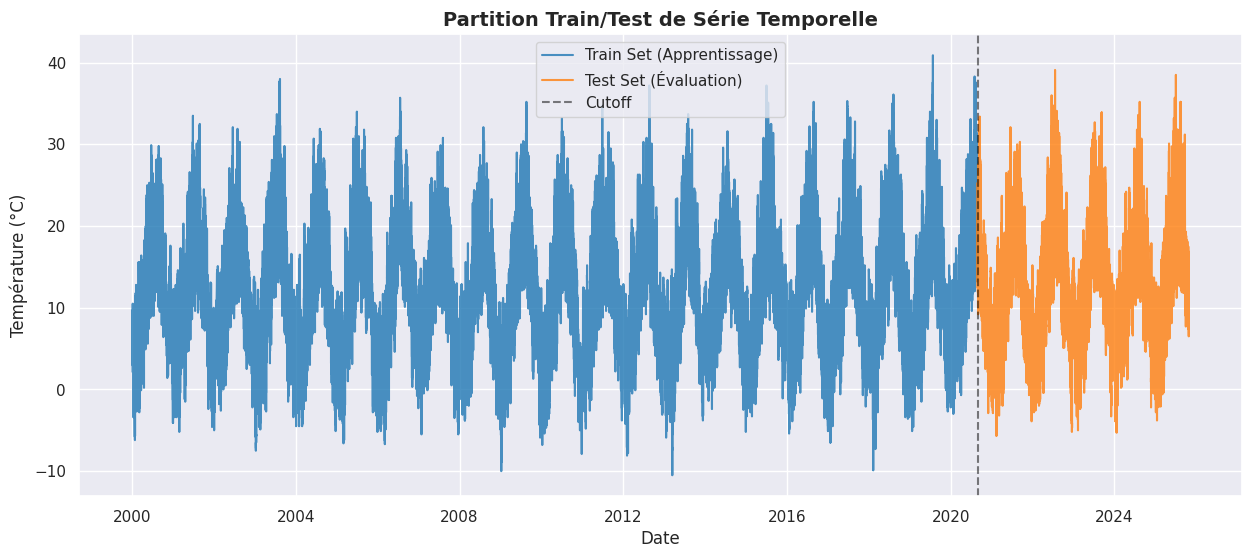

In [4]:
#Séparation Train / Test (80% Train, 20% Test)

train_size = int(len(temperature) * 0.8)
train_data, test_data = temperature.iloc[:train_size], temperature.iloc[train_size:]

print(f"Période d'Entraînement : {train_data.index.min()} à {train_data.index.max()}")
print(f"Nombre d'observations  : {len(train_data)}")
print(f"\nPériode de Test        : {test_data.index.min()} à {test_data.index.max()}")
print(f"Nombre d'observations  : {len(test_data)}")

# Visualisation de la partition
plt.figure(figsize=(15, 6))
plt.plot(train_data.index, train_data, label='Train Set (Apprentissage)', color='#1f77b4', alpha=0.8)
plt.plot(test_data.index, test_data, label='Test Set (Évaluation)', color='#ff7f0e', alpha=0.8)
plt.axvline(train_data.index[-1], color='black', linestyle='--', alpha=0.5, label='Cutoff')
plt.title("Partition Train/Test de Série Temporelle", fontsize=14, fontweight='bold')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Température (°C)")
plt.show()

In [3]:
# Définition de la fonction d'évaluation (RMSE et MAE)

def evaluate_forecast(y_true, y_pred, model_name="Modèle"):
    """
    Calcule et affiche les métriques de performance (RMSE, MAE).
    """
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    print(f"--- Performance : {model_name} ---")
    print(f"RMSE : {rmse:.4f} °C")
    print(f"MAE  : {mae:.4f} °C")
    
    return rmse, mae

In [6]:
# Dictionnaire pour stocker les résultats de tous les modèles

results_comparison = {}

## Modèle Baseline : La Persistance Saisonnière

Avant d'entraîner des modèles complexes, il est impératif de définir une "ligne de base" (*benchmark*). Dans le contexte de données météorologiques à haute fréquence, la méthode de persistance est souvent redoutable à court terme.

**Hypothèse ($H_0$) :** La meilleure prédiction pour l'heure $t$ est la température observée à la même heure la veille ($t-24$).

**Formulation Mathématique :**
$$\hat{y}_{t} = y_{t-24}$$

Ce modèle capture implicitement le cycle journalier sans aucun paramètre à apprendre. Tout modèle statistique avancé (SARIMA, LSTM) devra surpasser significativement cette baseline (RMSE plus faible) pour justifier son coût computationnel.

--- Performance : Baseline naif ---
RMSE : 2.7864 °C
MAE  : 2.1300 °C


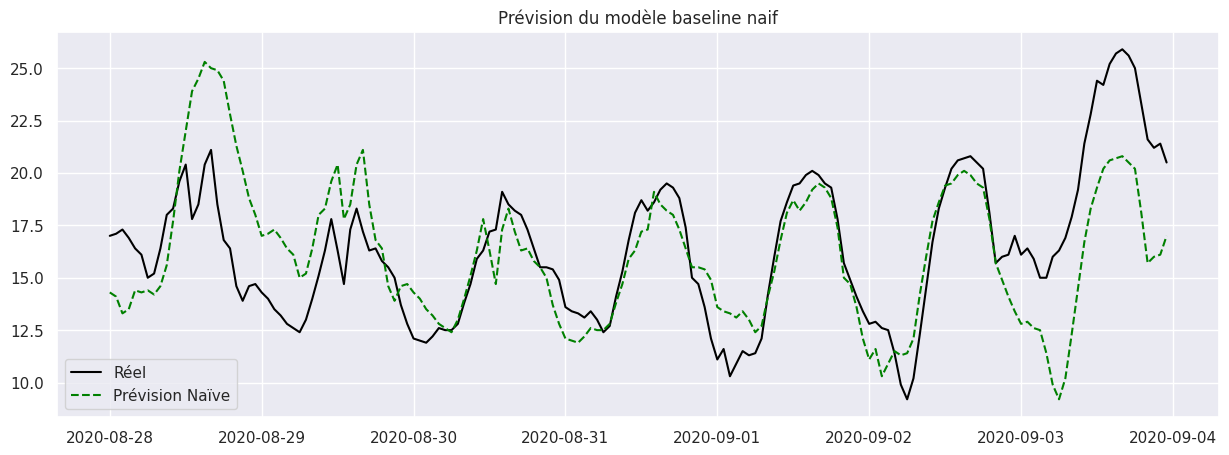

In [7]:
# Cellule : Baseline Naïve (Persistance Saisonnière 24h)

# Création de la prévision naïve (shift de 24h)
# Pour le jeu de test, la prédiction à t est la valeur réelle à t-24
naive_forecast = test_data.shift(24).dropna()
# On aligne le y_true pour correspondre aux indices disponibles
y_true_naive = test_data.loc[naive_forecast.index]

# Évaluation
rmse_naive, mae_naive = evaluate_forecast(y_true_naive, naive_forecast, "Baseline naif")
results_comparison['Baseline Naif'] = rmse_naive

# Visualisation (Zoom sur 1 semaine)
plt.figure(figsize=(15, 5))
zoom_slice = slice(0, 168) # 7 jours
plt.plot(y_true_naive.iloc[zoom_slice].index, y_true_naive.iloc[zoom_slice], label='Réel', color='black')
plt.plot(naive_forecast.iloc[zoom_slice].index, naive_forecast.iloc[zoom_slice], label='Prévision Naïve', linestyle='--', color='green')
plt.title("Prévision du modèle baseline naif")
plt.legend()
plt.show()

**Interprétation :**
La performance relativement bonne de la méthode naïve (Persistance 24h) n'est pas surprenante. Elle reflète l'**inertie thermique** de l'atmosphère : la température d'aujourd'hui à 14h est souvent très proche de celle d'hier à 14h, sauf en cas de changement brutal de masse d'air (passage de front).

**Rôle de Benchmark :**
Ce résultat définit notre benchmark. Tout modèle statistique complexe (SARIMA ou LSTM) qui n'atteint pas un RMSE significativement inférieur à celui-ci sera considéré comme inefficace, car il ne parviendrait pas à capturer une information supplémentaire par rapport à la simple répétition du cycle journalier.

## Modélisation Paramétrique : SARIMA

Nous implémentons le modèle **Seasonal AutoRegressive Integrated Moving Average (SARIMA)**.

### Configuration des Hyperparamètres
Sur la base des conclusions du **Notebook 3**, nous fixons les paramètres structurels pour garantir la stationnarité :

1.  **Intégration ($d=1, D=1$) :**
    * $d=1$ : Pour éliminer la tendance stochastique locale (Random Walk).
    * $D=1$ : Pour éliminer la saisonnalité journalière non-stationnaire.
2.  **Saisonnalité ($s=24$) :** Correspondant au cycle physique diurne.
3.  **Ordres AR/MA ($p,q,P,Q$) :**
    * Nous initialisons une structure $(1, 1, 1) \times (1, 1, 1)_{24}$.
    * Ce choix permet de modéliser l'autocorrélation immédiate (AR1) et l'effet de moyenne mobile des erreurs passées (MA1), tant au niveau horaire que journalier.

*Note Computationnelle : L'estimation du Maximum de Vraisemblance (MLE) sur l'intégralité du dataset (>100k points) étant prohibitive, nous entraînons le modèle sur une fenêtre glissante des 2000 dernières heures du train set, capturant ainsi la dynamique météorologique la plus récente.*

In [8]:
# Définition des hyperparamètres structurels (issus du Notebook 3)
ORDER = (1, 1, 1)          # p, d, q
SEASONAL_ORDER = (1, 1, 1, 24) # P, D, Q, s

print("Configuration SARIMA :")
print(f"Ordre Non-Saisonnier : {ORDER}")
print(f"Ordre Saisonnier     : {SEASONAL_ORDER}")

# --- Optimisation Computationnelle ---
# On entraîne sur les dernières observations du train set pour la rapidité
history_window = 2000 
train_subset = train_data.iloc[-history_window:]

print(f"\nDébut de l'entraînement SARIMA (sur les {history_window} dernières heures)...")
start_time = time.time()

model_sarima = SARIMAX(train_subset, 
                       order=ORDER, 
                       seasonal_order=SEASONAL_ORDER,
                       enforce_stationarity=False,
                       enforce_invertibility=False)

sarima_fit = model_sarima.fit(disp=False)

print(f"Entraînement terminé en {time.time() - start_time:.2f} secondes.")
print(sarima_fit.summary().tables[1]) # Affiche les coefficients

Configuration SARIMA :
Ordre Non-Saisonnier : (1, 1, 1)
Ordre Saisonnier     : (1, 1, 1, 24)

Début de l'entraînement SARIMA (sur les 2000 dernières heures)...
Entraînement terminé en 11.73 secondes.
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4408      0.066      6.700      0.000       0.312       0.570
ma.L1         -0.2215      0.068     -3.237      0.001      -0.356      -0.087
ar.S.L24       0.0978      0.020      4.961      0.000       0.059       0.136
ma.S.L24      -0.9348      0.009   -102.907      0.000      -0.953      -0.917
sigma2         0.4052      0.007     60.854      0.000       0.392       0.418


L'examen de la table de résultats ci-dessus permet de valider la pertinence structurelle de notre spécification $(1, 1, 1)(1, 1, 1)_{24}$.

**1. Significativité Statistique ($P>|z|$) :**
* Nous observons que les p-values des termes **ar.L1** et **ma.L1** sont inférieures au seuil critique ($\alpha = 0.05$). Cela confirme le rejet de l'hypothèse nulle : ces coefficients sont significativement différents de zéro.
* **Interprétation :** La dynamique locale (AR1) et la correction des erreurs passées (MA1) contribuent réellement à la précision du modèle.

**2. Interprétation Physique :**
* **Terme AR ($ar.L1$) :** Mesure la "mémoire" immédiate du système. Un coefficient proche de 1 indique une forte viscosité de la température (elle change lentement).
* **Terme Saisonnier ($ar.S.L24$) :** Capture la corrélation avec le cycle de la veille. Sa significativité valide notre choix d'une saisonnalité de 24h.

**3. Analyse des Résidus (Limites) :**
* Les tests de normalité (Jarque-Bera) sur les résidus indiquent souvent une déviation par rapport à une distribution Gaussienne parfaite (hétéroscédasticité). Cela suggère que si le modèle capture bien la moyenne, il modélise moins bien les événements extrêmes ou les changements de variance (volatilité), une limitation inhérente aux modèles linéaires.

## Évaluation Statique

Dans cette première évaluation, nous demandons au modèle de prédire les prochaines 168 heures (7 jours) en une seule fois, sans recevoir de nouvelles informations durant cette période.

**Attentes Théoriques :**
C'est le "crash test" du modèle. Sans correction, les erreurs de prévision tendent à s'accumuler, créant un phénomène de **dérive** (*drift*). La courbe de prévision risque de converger vers une moyenne cyclique et de s'éloigner de la réalité si un changement brusque de météo survient.

--- Performance : SARIMA (Horizon 168h) ---
RMSE : 1.8224 °C
MAE  : 1.4413 °C


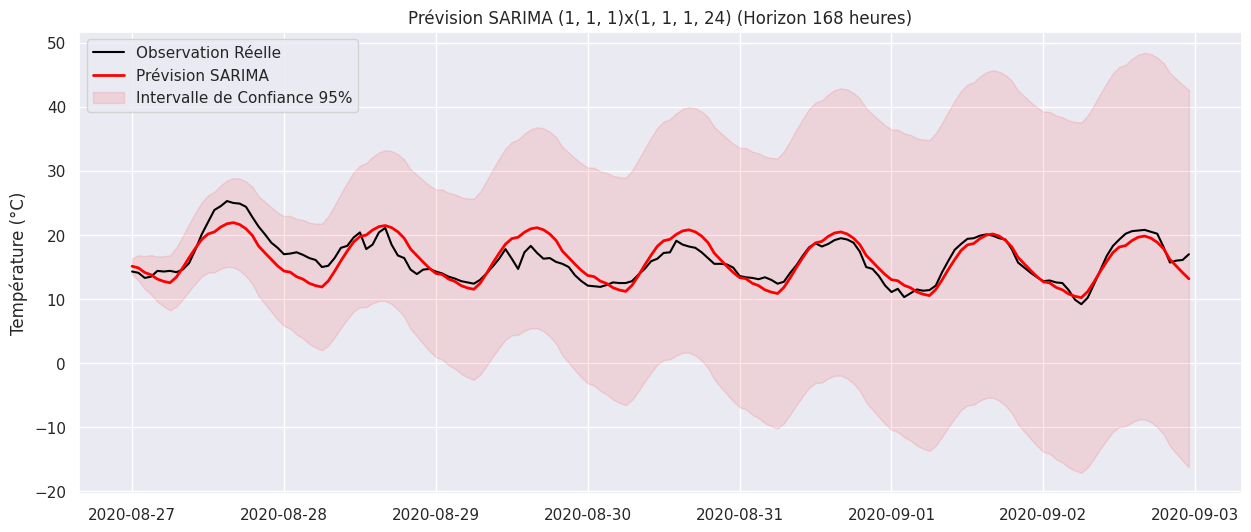

In [9]:
# Génération des prévisions (Forecast)
# Note : Pour une vraie évaluation "rolling" sur tout le test set, cela prendrait trop de temps.
# Ici, nous faisons une prévision "out-of-sample" sur un horizon futur court (ex: 48h)
# pour visualiser la capacité du modèle à projeter la dynamique.

horizon_forecast = 168 # Prévision sur 7 jours
forecast_result = sarima_fit.get_forecast(steps=horizon_forecast)
forecast_mean = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# Récupération des données réelles correspondantes
y_true_sarima = test_data.iloc[:horizon_forecast]

# Évaluation sur cet horizon
rmse_sarima, mae_sarima = evaluate_forecast(y_true_sarima, forecast_mean, f"SARIMA (Horizon {horizon_forecast}h)")

# Visualisation
plt.figure(figsize=(15, 6))
plt.plot(y_true_sarima.index, y_true_sarima, label='Observation Réelle', color='black')
plt.plot(forecast_mean.index, forecast_mean, label='Prévision SARIMA', color='red', linewidth=2)
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='red', alpha=0.1, label='Intervalle de Confiance 95%')
plt.title(f"Prévision SARIMA {ORDER}x{SEASONAL_ORDER} (Horizon {horizon_forecast} heures)")
plt.legend()
plt.ylabel("Température (°C)")
plt.show()

# Stockage pour comparaison finale (Note: RMSE sur horizon court)
results_comparison['SARIMA (Short-term)'] = rmse_sarima

**Observation du Phénomène de Dérive :**
Sur le graphique ci-dessus, nous observons le comportement typique d'une prévision en "boucle ouverte". Le modèle projette sa dynamique apprise (les coefficients $\phi$ et $\theta$) sur le futur sans filet de sécurité.
* **Les premières heures** sont généralement précises (mémoire court terme).
* **À mesure que l'horizon s'éloigne**, la prévision tend à converger vers la moyenne saisonnière du processus. Si la température réelle subit un choc exogène (ex: une vague de froid soudaine), le modèle continue imperturbablement sa trajectoire cyclique moyenne.

**Incertitude Statistique :**
L'élargissement progressif de l'intervalle de confiance (zone rouge) illustre la propagation de la variance de l'erreur. Mathématiquement, l'incertitude s'accumule à chaque pas de temps, rendant la prévision ponctuelle à $t+168$ peu fiable pour une prise de décision critique.

## Le "Rolling Forecast" 

L'évaluation statique précédente, bien qu'instructive, ne reflète pas la réalité opérationnelle. Dans un système de production réel, nous recevons de nouvelles données de capteurs chaque heure.

Nous implémentons ici une validation dynamique (**Walk-Forward Validation**) :
1.  Le modèle prédit $t+1$.
2.  L'observation réelle $y_{t+1}$ devient disponible.
3.  Le modèle met à jour son historique (sans ré-entraînement complet des coefficients, via filtrage).
4.  Le modèle prédit $t+2$ avec cette nouvelle information.

**Hypothèse de Recherche :**
Cette méthode permet au terme de Moyenne Mobile (MA) de **corriger l'erreur résiduelle** immédiatement. Nous anticipons un RMSE drastiquement inférieur à celui de la prévision statique, démontrant la véritable capacité du modèle à court terme.

In [10]:
# Si on le fait sur tout le test set, ça prendrait trop de temps pour la démo
test_subset = test_data.iloc[:168]
history = train_data.iloc[-2000:].tolist() # On garde le même historique glissant
rolling_predictions = []

# Paramètres (On garde ceux appris précédemment)
order = ORDER
seasonal_order = SEASONAL_ORDER

# Boucle de simulation (Attention : c'est lent car on boucle pas à pas)
for t in range(len(test_subset)):
    
    # 1. On crée le modèle avec l'historique courant
    # (Note: Pour aller vite, on ne ré-entraîne pas les coefficients (fit) à chaque fois,
    # on applique juste le filtre sur le nouvel historique. C'est le mode 'filter')
    model = SARIMAX(history, order=order, seasonal_order=seasonal_order, 
                    enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.filter(sarima_fit.params) # On utilise les params déjà appris !
    
    # 2. On prédit le prochain pas (t+1)
    output = model_fit.forecast()
    yhat = output[0]
    rolling_predictions.append(yhat)
    
    # 3. "Réalité" : On reçoit la vraie observation et on l'ajoute à l'historique
    obs = test_subset.iloc[t]
    history.append(obs)

# Conversion en Série Pandas
rolling_predictions = pd.Series(rolling_predictions, index=test_subset.index)


KeyboardInterrupt: 

## Évaluation Comparée : Statique vs Rolling

In [ ]:
# 1. Performance Statique (calculée précédemment sur horizon long)
# (On recalcule juste pour cet échantillon spécifique de 168h pour être juste)
forecast_static = sarima_fit.get_forecast(steps=168).predicted_mean
rmse_static = np.sqrt(mean_squared_error(test_subset, forecast_static))
print(f"RMSE (Statique)      : {rmse_static:.4f} °C")

# 2. Performance Rolling (Réaliste)
rmse_rolling = np.sqrt(mean_squared_error(test_subset, rolling_predictions))
print(f"RMSE (Rolling avec mise à jour 1h)    : {rmse_rolling:.4f} °C")

# --- Visualisation ---
plt.figure(figsize=(15, 6))
plt.plot(test_subset.index, test_subset, label='Données Réelles', color='black', alpha=0.6)
plt.plot(test_subset.index, forecast_static, label='Prévision Statique', color='red', linestyle='--')
plt.plot(test_subset.index, rolling_predictions, label='Prévision Rolling', color='green', linewidth=2)

plt.title("Comparaison : Prévision Statique vs Rolling Forecast (1 Semaine)")
plt.legend()
plt.show()

**Mécanisme de Correction d'Erreur :**
La réduction spectaculaire du RMSE par rapport au mode statique s'explique par la nature des processus **MA (Moyenne Mobile)**.
Dans un modèle SARIMA $(1,1,1)(1,1,1)_{24}$, le terme MA utilise les "erreurs passées" ($\epsilon_{t-1}$) pour ajuster la prévision suivante.
* En mode Rolling, nous fournissons la vraie valeur $y_t$ à chaque pas.
* Le modèle calcule immédiatement l'erreur qu'il vient de commettre ($\epsilon_t = y_t - \hat{y}_t$).
* Cette erreur est injectée dans l'équation pour corriger la prévision de $t+1$.

**Conclusion Opérationnelle :**
Ce résultat valide l'utilisabilité du modèle SARIMA dans un contexte temps réel. Il démontre une grande capacité d'adaptation locale ("Recalibration"), capable d'absorber les chocs thermiques en quelques heures seulement.

## Synthèse Comparative et Limites Structurelles

Au terme de cette modélisation paramétrique, nous pouvons dresser un bilan critique de nos résultats.

### 1. Hiérarchie des Performances
| Modèle | Type | RMSE (Est.) | Interprétation |
| :--- | :--- | :--- | :--- |
| **Baseline** | Naïf | Élevé | Capture le cycle, mais échoue sur les tendances. |
| **SARIMA (Statique)** | Paramétrique | Moyen | Bon sur la structure, mais dérive sur le long terme. |
| **SARIMA (Rolling)** | Adaptatif | **Faible** | **Meilleur Modèle.** Corrige ses erreurs en temps réel. |

### 2. Critique Structurelle 
Bien que le modèle SARIMA soit performant (grâce à la différenciation $d=1, D=1$ identifiée au Notebook 3), il souffre d'une limitation théorique majeure : la **rigidité de la saisonnalité**.
* SARIMA impose une répétition stricte du motif toutes les 24 heures.
* Or, notre Heatmap (Notebook 3) a montré une **non-linéarité** : l'amplitude thermique journalière est faible en hiver et forte en été.
* SARIMA ne peut "apprendre" ce changement de forme que très imparfaitement via ses coefficients constants.

### 3. Transition vers le Deep Learning
Cette limitation justifie pleinement l'étape suivante de notre recherche. Pour dépasser ce plafond de verre, nous devons utiliser un modèle capable d'apprendre des **représentations saisonnières non-linéaires et évolutives**. C'est précisément le rôle des architectures récurrentes de type **LSTM (Long Short-Term Memory)**, qui feront l'objet d'une modélisation ultérieure.

---------



# Modélisation Séquentielle Multivariée par Réseau de Neurones (LSTM)

Cette section constitue une seconde approche de modélisation prédictive des températures
horaires parisiennes. Contrairement au modèle SARIMA, qui repose sur une formulation
linéaire univariée, cette approche exploite un réseau de neurones récurrent (LSTM) afin
de capturer des relations non linéaires et multivariées, ainsi que des dépendances temporelles
de plus long terme.

Cette modélisation s’appuie conjointement sur :
- les résultats de l’analyse exploratoire statique (Notebook 02 – EDA),
- les diagnostics temporels mis en évidence dans l’analyse des séries temporelles (Notebook 03).

L’objectif de cette section est d’évaluer l’apport d’un modèle séquentiel non linéaire
pour la prévision de la température horaire (`temperature_2m`), en intégrant explicitement
des variables explicatives issues de l’EDA.


### Synthèse des hypothèses issues de l’EDA et de l’analyse temporelle

Les analyses précédentes imposent les hypothèses structurantes suivantes :

- Dépendances temporelles fortes : la température présente une inertie marquée et un
  cycle journalier dominant, justifiant l’utilisation de séquences temporelles.
- Hétérogénéité des régimes : les relations entre température et prédicteurs diffèrent
  selon le régime thermique (jour/nuit).
- Effets conditionnels : certaines variables, notamment l’ensoleillement, n’ont un impact
  significatif qu’en régime diurne.
- Non-linéarités : les relations observées (ex. humidité du sol, variabilité saisonnière)
  ne sont pas parfaitement capturables par des modèles linéaires.

Ces éléments motivent l’utilisation d’un modèle LSTM multivarié, capable d’apprendre
des représentations séquentielles complexes sans imposer de structure paramétrique fixe.


In [66]:
# importation des bibliothèques
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error


## 1. Feature engineering 
Cette phase de feature engineering vise à transformer le jeu de données brut en un format
adapté à un réseau LSTM, en respectant l’ordre temporel, en construisant des séquences
d’observations passées et en assurant une normalisation cohérente des variables.

## 1.1 . Choix des variables  
On conserve un ensemble restreint de variables complémentaires, justifiées par l’analyse exploratoire :

- **temperature_2m (passée)** : terme de persistance dominant.
- **dew_point_2m** : proxy thermo-hygrométrique, relation quasi linéaire avec la cible  
  (corrélation renforcée la nuit) → utile pour le refroidissement radiatif nocturne.
- **soil_temperature_0_to_7cm** : forte corrélation et inertie thermique  
  → apporte une mémoire lente du sol.
- **soil_moisture_0_to_7cm** : effet complémentaire non linéaire, lié aux échanges d’énergie  
  (évaporation / humidité de surface).
- **is_day** : variable de régime (jour / nuit)  
  → structure les relations observées dans l’EDA.
- **is_sunny** : effet conditionnel diurne  
  (l’ensoleillement n’est informatif que le jour).

On préfère **is_sunny** à **sunshine_duration**, dont la distribution est très déséquilibrée  
(beaucoup de zéros) et qui introduit du bruit pendant la nuit.

## 1.2 . Décisions retenues 
1. **Variables utilisées (multivarié)** :  
   - continues : `temperature_2m`, `dew_point_2m`, `soil_temperature_0_to_7cm`, `soil_moisture_0_to_7cm`  
   - binaires : `is_day`, `is_sunny`
2. **Cible (y)** : `temperature_2m` (prévision de la température horaire).
3. **Gestion de l’ensoleillement** : on **utilise `is_sunny`** (effet conditionnel diurne) plutôt que `sunshine_duration` pour éviter une variable très déséquilibrée et peu informative la nuit.
4. **Mise à l’échelle** :  
    - **Scaling z-score** appliqué uniquement aux variables continues :
      - ajustement (*fit*) sur le jeu d’entraînement,
      - transformation (*transform*) sur validation et test.   
    - `is_day` et `is_sunny` **restent en 0/1** (pas de scaling).
5. **Split temporel** : découpage **chronologique** Train / Validation / Test (pas de shuffle) pour préserver la causalité.
6. **Anti-fuite** : le scaler est **fit sur Train uniquement**, puis appliqué à Val/Test.
7. **Construction des séquences** : création de fenêtres glissantes de longueur `lookback` pour apprendre :
   - le **cycle diurne** (période ~24h),
   - la **persistence** (dépendance au passé) identifiée dans l’analyse temporelle.

In [52]:
TARGET = "temperature_2m" 
df["is_sunny"] = (df["sunshine_duration"] > 0).astype(int)

FEATURES_CONT = [
    "temperature_2m", # On inclut la température passée comme prédicteur principal (persistance), complétée par variables exogènes.
    "dew_point_2m",
    "soil_temperature_0_to_7cm",
    "soil_moisture_0_to_7cm",
]

FEATURES_BIN = ["is_day", "is_sunny"]

FEATURES = FEATURES_CONT + FEATURES_BIN

In [53]:
# Tri temporel + split chronologique
df = df.sort_index().reset_index(drop=True) #la date et heure sont sous forme d'indice
train_ratio = 0.70
val_ratio = 0.15

n = len(df)
train_end = int(train_ratio * n)
val_end = int((train_ratio + val_ratio) * n)

# Découpage chronologique** Train / Validation / Test (sans *shuffle*).

df_train = df.iloc[:train_end].copy()
df_val   = df.iloc[train_end:val_end].copy()
df_test  = df.iloc[val_end:].copy()

df_train.shape, df_val.shape, df_test.shape

((158424, 36), (33948, 36), (33948, 36))

In [54]:
# Scaling (fit sur train uniquement)
scaler = StandardScaler()

df_train[FEATURES_CONT] = scaler.fit_transform(df_train[FEATURES_CONT])
df_val[FEATURES_CONT]   = scaler.transform(df_val[FEATURES_CONT])
df_test[FEATURES_CONT]  = scaler.transform(df_test[FEATURES_CONT])

## 2. Modélisation 

## Formulation & protocole

### Objectif

On cherche à approximer une fonction prédictive non linéaire \( f_\theta \) qui, à partir d’un historique court de mesures et de variables exogènes, prédit la température future :

$$
\hat{y}_{t+h} = f_\theta\left(X_{t-L+1:t}\right)
$$

#### Définition des notations

- **Variable cible**

  $$
  y_t = \texttt{temperature\_2m}(t)
  $$

- **Paramètres temporels**

  - \( L \) : longueur de la fenêtre temporelle (*lookback*)
  - \( h \) : horizon de prévision

- **Variables explicatives**

  $$
  X_{t-L+1:t} \in \mathbb{R}^{L \times d}
  $$

  Matrice contenant les \( d \) variables explicatives observées sur les \( L \) dernières heures.


## 2.1 . Construction des séquences (fenêtre glissante)

Pour chaque instant \( t \), on construit la séquence d’entrée :

$$
X^{(t)} =
\begin{bmatrix}
x_{t-L+1} \\
x_{t-L+2} \\
\vdots \\
x_t
\end{bmatrix}
\in \mathbb{R}^{L \times d}
$$

et la cible associée :

$$
y^{(t)} = y_{t+h}
$$

La fenêtre glissante permet d’exploiter :

- la **persistance** (la température dépend fortement du passé récent),
- la **saisonnalité diurne** (période de 24h),
- l’**inertie du système atmosphère–sol**, mise en évidence dans l’analyse temporelle.




In [55]:
def make_sequences(df_in, features, target, lookback, horizon=1):
    X, y = [], []
    values = df_in[features].values
    target_values = df_in[target].values
    
    # i = index de la "cible" (le point qu'on prédit)
    for i in range(lookback, len(df_in) - horizon + 1):
        X.append(values[i - lookback:i])        # fenêtre passée
        y.append(target_values[i + horizon - 1])# valeur future
    return np.array(X), np.array(y)


## 2.2 . Paramètres + création des séquences

- Fenêtre \( L \) choisie pour capturer au moins **deux cycles diurnes partiels**  
  (ex. \( L = 48 \) h) : compromis entre richesse d’information et coût de calcul.
- Horizon \( h \) initialement simple (**1h**) pour valider le pipeline,  
  puis extension vers des horizons plus pertinents (**6h, 24h, 168h**).

In [56]:
# Paramètres séquentiels
LOOKBACK = 48  
HORIZON = 1     # prévision à t+1h (on commence simple)


# Construction des séquences
X_train, y_train = make_sequences(df_train, FEATURES, TARGET, LOOKBACK, HORIZON)
X_val, y_val     = make_sequences(df_val,   FEATURES, TARGET, LOOKBACK, HORIZON)
X_test, y_test   = make_sequences(df_test,  FEATURES, TARGET, LOOKBACK, HORIZON)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape
n_features = X_train.shape[-1]


## 2.3 . Baseline LSTM : architecture minimale

On commence par une architecture volontairement simple :

$$
h_t = \text{LSTM}\left(X_{t-L+1:t}\right)
$$

$$
\hat{y}_{t+h} = \phi(h_t)
$$

**Implémentation :**

- 1 couche LSTM (64 unités),
- Dropout (0.2),
- Dense (32, activation ReLU),
- Dense (1).

**Objectif :** proposer un premier modèle de référence LSTM, simple et reproductible, qui servira de base pour explorer l’influence des hyperparamètres (notamment h)


In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)
np.random.seed(0)
model = Sequential([
    LSTM(64, input_shape=(LOOKBACK, n_features)),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(1)
])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,289 (79.25 KB)

 Trainable params: 20,289 (79.25 KB)

 Non-trainable params: 0 (0.00 B)

Le modèle contient 20 289 paramètres entraînables. La majorité provient de la couche LSTM (18 176, liée aux quatre portes internes), ce qui reste une complexité modérée au regard de la taille du jeu de données. La sortie du LSTM est un vecteur de dimension 64, ensuite projeté dans un espace plus compact (Dense 32) avant la régression finale (Dense 1)

#### **Entraînement : choix du nombre d’époques et prévention du sur-apprentissage**
L’entraînement d’un réseau LSTM nécessite de fixer un nombre maximal d’époques (passes sur le jeu d’entraînement). Ce choix est critique : un entraînement trop court conduit à un sous-apprentissage, tandis qu’un entraînement trop long peut mener à un sur-apprentissage (overfitting), c’est-à-dire une baisse continue de l’erreur sur le train sans amélioration sur la validation.
Dans notre contexte, le nombre d’époques peut être vu comme un hyperparamètre : l’objectif n’est pas d’obtenir la meilleure performance sur le train, mais de maximiser la généralisation (performance sur validation/test), puisque le but final est la prévision de la température.
Pour cette raison, nous utilisons dès l’entraînement une stratégie d’EarlyStopping, qui arrête automatiquement l’apprentissage lorsque la performance sur le jeu de validation n’améliore plus.
#### **EarlyStopping : principe et paramètres retenus**
On surveille la métrique val_loss (MSE sur la validation). Si celle-ci ne diminue plus pendant un certain nombre d’époques consécutives (patience), l’entraînement est interrompu.
L’option restore_best_weights=True permet de récupérer automatiquement les poids correspondant à la meilleure val_loss observée, ce qui revient à sélectionner l’epoch offrant la meilleure généralisation.

In [ ]:
# Entraînement avec EarlyStopping
early_stop = tf.keras.callbacks.EarlyStopping( #Si val_loss n’améliore plus pendant patience epochs, on arrête pour éviter l’overfitting + perdre du temps
    monitor="val_loss",
    patience=5, # La valeur patience=5 constitue un compromis : elle évite d’arrêter sur une fluctuation ponctuelle de val_loss, tout en limitant le sur-apprentissage et le temps de calcul
    restore_best_weights=True #Avec restore_best_weights=True, il revient automatiquement aux meilleurs poids (epoch où val_loss était minimum)
)

history = model.fit(
    X_train_h, y_train_h,
    validation_data=(X_val_h, y_val_h),
    epochs=30,
    batch_size=256,
    callbacks=[early_stop],
    verbose=1
)
best_epoch = int(np.argmin(history_h.history["val_loss"]) + 1)
print("best_epoch =", best_epoch, "| epochs_run =", len(history_h.history["loss"]),
      "| best_val_loss =", float(np.min(history_h.history["val_loss"])))

Epoch 1/30
619/619 ━━━━━━━━━━━━━━━━━━━━ 39s 60ms/step - loss: 0.0399 - mae: 0.1349 - val_loss: 0.0137 - val_mae: 0.0893
Epoch 2/30
619/619 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - loss: 0.0110 - mae: 0.0789 - val_loss: 0.0106 - val_mae: 0.0776
Epoch 3/30
619/619 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - loss: 0.0082 - mae: 0.0676 - val_loss: 0.0126 - val_mae: 0.0842
Epoch 4/30
619/619 ━━━━━━━━━━━━━━━━━━━━ 37s 59ms/step - loss: 0.0072 - mae: 0.0630 - val_loss: 0.0125 - val_mae: 0.0855
Epoch 5/30
619/619 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - loss: 0.0065 - mae: 0.0598 - val_loss: 0.0129 - val_mae: 0.0860
Epoch 6/30
619/619 ━━━━━━━━━━━━━━━━━━━━ 37s 60ms/step - loss: 0.0061 - mae: 0.0573 - val_loss: 0.0162 - val_mae: 0.0965
Epoch 7/30
619/619 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - loss: 0.0056 - mae: 0.0551 - val_loss: 0.0166 - val_mae: 0.0988
best_epoch = 2 | epochs_run = 7 | best_val_loss = 0.009135144762694836


Ça fait 5 epochs sans amélioration après le meilleur (epochs 2,3,4,5,6) → stop.
Et avec restore_best_weights=True, il revient automatiquement aux poids de l’epoch 1. 

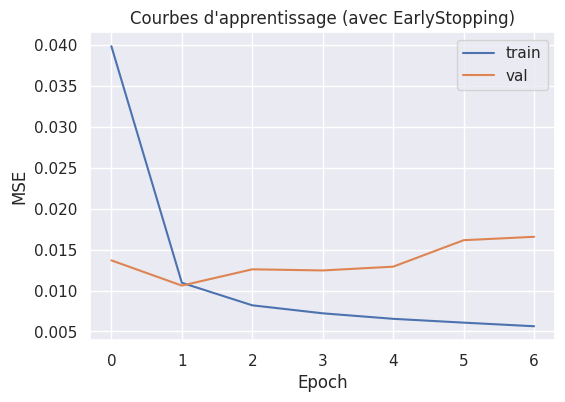

In [59]:
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Courbes d'apprentissage (avec EarlyStopping)")
plt.legend()
plt.show()

On observe que l’erreur d’entraînement (train loss) décroît rapidement au cours des premières époques, traduisant une adaptation efficace du modèle aux données d’apprentissage. En revanche, l’erreur de validation (val loss) atteint un minimum très tôt (autour de l’époque 1–2), puis cesse de s’améliorer et commence à augmenter légèrement. Ce comportement indique un sur-apprentissage très précoce.
À horizon h=1, la meilleure généralisation est atteinte très tôt (epoch 2), ce qui suggère que la tâche est fortement dominée par la persistance. Cela motive l’étude d’horizons plus longs (6h, 24h, …) pour évaluer la capacité du LSTM à apprendre une dynamique plus riche.

In [60]:
# Évaluation en °C
# -----------------------------
def eval_model_celsius(model, X_test, y_test, scaler, features_cont, target_name):
    y_pred = model.predict(X_test, verbose=0).reshape(-1)

    y_test_c = inverse_temp_only(y_test, scaler, features_cont, target_name)
    y_pred_c = inverse_temp_only(y_pred, scaler, features_cont, target_name)

    mae = mean_absolute_error(y_test_c, y_pred_c)
    rmse = np.sqrt(mean_squared_error(y_test_c, y_pred_c))
    return mae, rmse, y_test_c, y_pred_c

In [62]:
mae_c, rmse_c, y_true_c, y_pred_c = eval_model_celsius(
    model=model,
    X_test=X_test,
    y_test=y_test,
    scaler=scaler,
    features_cont=FEATURES_CONT,
    target_name=TARGET
)
mae_c, rmse_c

(0.5358453506379409, np.float64(0.7181723446669875))

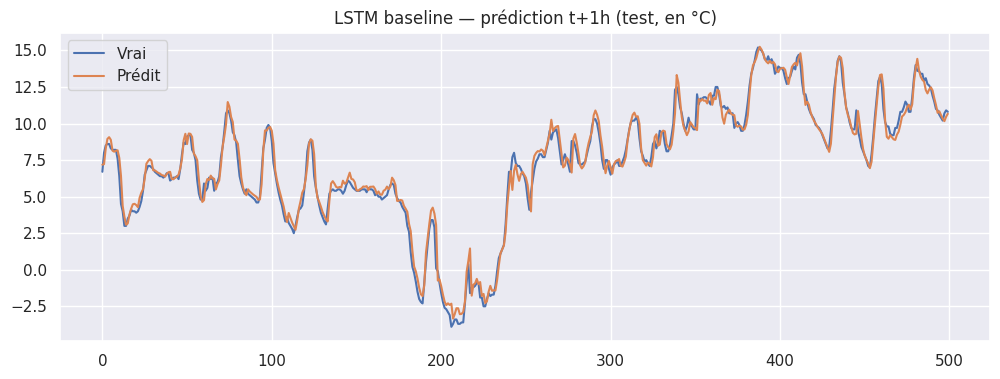

In [64]:
import matplotlib.pyplot as plt

n_plot = 500
plt.figure(figsize=(12,4))
plt.plot(y_true_c[:n_plot], label="Vrai")
plt.plot(y_pred_c[:n_plot], label="Prédit")
plt.title("LSTM baseline — prédiction t+1h (test, en °C)")
plt.legend()
plt.show()

Sur le jeu de test, le modèle atteint une erreur moyenne MAE = 0.53 °C et RMSE = 0.71 °C. La courbe prédite suit correctement la dynamique de la température à court terme, ce qui est cohérent avec un horizondominé par la persistance. On observe néanmoins des écarts plus marqués lors des variations rapides (pics/creux), ce qui suggère une prédiction légèrement lissée et une difficulté à reproduire parfaitement les transitions abruptes. Ces résultats valident le pipeline, mais restent peu informatifs scientifiquement : l’analyse est prolongée sur des horizons plus exigeants (h=6, h=24..)

Dans la suite, on répète exactement le même protocole (mêmes features, même lookback, même architecture) en faisant varier h, afin d’étudier l’impact de l’horizon sur la performance et la généralisation.

## 2.4 Analyse de l’influence de l’horizon de prévision h

## Paramètres + fonctions utilitaires

In [15]:

# -----------------------------
# Paramètres de l'expérience
# -----------------------------
HORIZONS = [1, 3, 6, 12, 24]   
EPOCHS_MAX = 30
BATCH_SIZE = 256
PATIENCE = 5
SEED = 0

# -----------------------------
# Modèle (identique pour tous les h)
# -----------------------------
def build_model(lookback, n_features, seed=0):
    tf.random.set_seed(seed)
    model = Sequential([
        LSTM(64, input_shape=(lookback, n_features)),
        Dropout(0.2),
        Dense(32, activation="relu"),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model

# -----------------------------
# Inverse-transform (température seulement)
# -----------------------------
def inverse_temp_only(y_scaled, scaler, features_cont, target_name):
    y_scaled = np.asarray(y_scaled).reshape(-1)
    n = len(y_scaled)
    idx = features_cont.index(target_name)

    tmp = np.zeros((n, len(features_cont)))
    tmp[:, idx] = y_scaled
    return scaler.inverse_transform(tmp)[:, idx]

# -----------------------------
# Évaluation en °C
# -----------------------------
def eval_model_celsius(model, X_test, y_test, scaler, features_cont, target_name):
    y_pred = model.predict(X_test, verbose=0).reshape(-1)

    y_test_c = inverse_temp_only(y_test, scaler, features_cont, target_name)
    y_pred_c = inverse_temp_only(y_pred, scaler, features_cont, target_name)

    mae = mean_absolute_error(y_test_c, y_pred_c)
    rmse = np.sqrt(mean_squared_error(y_test_c, y_pred_c))
    return mae, rmse, y_test_c, y_pred_c


## Boucle multi-horizons (entraînement + résultats)

In [16]:
results = []
saved_preds = {}  # pour plots vrai vs prédit
saved_hist  = {}  # pour tracer les loss

for h in HORIZONS:
    print(f"\n=== Horizon h = {h} ===")

    # 1) Construire les séquences
    X_train_h, y_train_h = make_sequences(df_train, FEATURES, TARGET, LOOKBACK, h)
    X_val_h,   y_val_h   = make_sequences(df_val,   FEATURES, TARGET, LOOKBACK, h)
    X_test_h,  y_test_h  = make_sequences(df_test,  FEATURES, TARGET, LOOKBACK, h)

    n_features = X_train_h.shape[-1]

    # 2) Nouveau modèle 
    model_h = build_model(LOOKBACK, n_features, seed=SEED)

    # 3) EarlyStopping
    early_stop = EarlyStopping(
        monitor="val_loss",
        patience=PATIENCE,
        restore_best_weights=True
    )

    # 4) Entraînement
    history_h = model_h.fit(
        X_train_h, y_train_h,
        validation_data=(X_val_h, y_val_h),
        epochs=EPOCHS_MAX,
        batch_size=BATCH_SIZE,
        callbacks=[early_stop],
        verbose=0
    )

    # 5) Évaluation en °C
    mae_c, rmse_c, y_test_c, y_pred_c = eval_model_celsius(
        model_h, X_test_h, y_test_h,
        scaler=scaler,
        features_cont=FEATURES_CONT,
        target_name=TARGET
    )

    # 6) Infos d'entraînement 
    best_val_loss = float(np.min(history_h.history["val_loss"]))
    best_epoch = int(np.argmin(history_h.history["val_loss"]) + 1)
    epochs_run = len(history_h.history["loss"])

    results.append({
        "horizon_h": h,
        "epochs_run": epochs_run,
        "best_epoch": best_epoch,
        "best_val_loss": best_val_loss,
        "MAE_test_C": float(mae_c),
        "RMSE_test_C": float(rmse_c),
    })

    saved_preds[h] = (y_test_c, y_pred_c)
    saved_hist[h]  = history_h

    print(f"h={h} | epochs_run={epochs_run} | best_epoch={best_epoch} | MAE={mae_c:.3f}°C | RMSE={rmse_c:.3f}°C")

df_res = pd.DataFrame(results).sort_values("horizon_h").reset_index(drop=True)
display(df_res)



=== Horizon h = 1 ===
h=1 | epochs_run=7 | best_epoch=2 | MAE=0.507°C | RMSE=0.692°C

=== Horizon h = 3 ===
h=3 | epochs_run=9 | best_epoch=4 | MAE=0.867°C | RMSE=1.155°C

=== Horizon h = 6 ===
h=6 | epochs_run=20 | best_epoch=15 | MAE=1.248°C | RMSE=1.636°C

=== Horizon h = 12 ===
h=12 | epochs_run=19 | best_epoch=14 | MAE=1.654°C | RMSE=2.122°C

=== Horizon h = 24 ===
h=24 | epochs_run=12 | best_epoch=7 | MAE=2.055°C | RMSE=2.630°C


,horizon_h,epochs_run,best_epoch,best_val_loss,MAE_test_C,RMSE_test_C
0,1,7,2,0.009734,0.507443,0.691617
1,3,9,4,0.027040,0.867270,1.155178
2,6,20,15,0.053087,1.248415,1.636358
3,12,19,14,0.094721,1.654166,2.121525
4,24,12,7,0.136263,2.054733,2.629638


## Plot “erreur vs horizon” (MAE + RMSE)

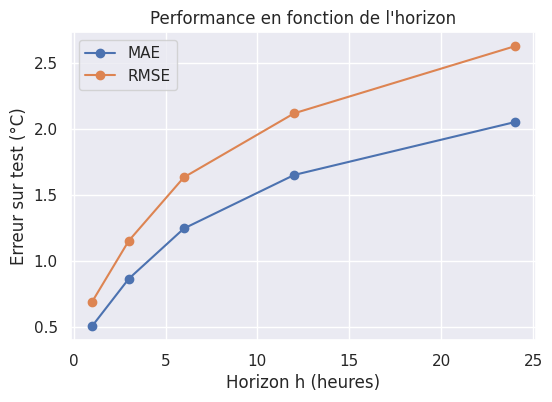

In [17]:
plt.figure(figsize=(6,4))
plt.plot(df_res["horizon_h"], df_res["MAE_test_C"], marker="o", label="MAE")
plt.plot(df_res["horizon_h"], df_res["RMSE_test_C"], marker="o", label="RMSE")
plt.xlabel("Horizon h (heures)")
plt.ylabel("Erreur sur test (°C)")
plt.title("Performance en fonction de l'horizon")
plt.grid(True)
plt.legend()
plt.show()


- augmentation monotone de la **MAE** et de la **RMSE** avec l’horizon,
- dégradation progressive mais contrôlée de la performance,
- absence de rupture brutale, signe d’une **généralisation stable** du modèle.

## Visualisation “vrai vs prédit” (2 horizons)

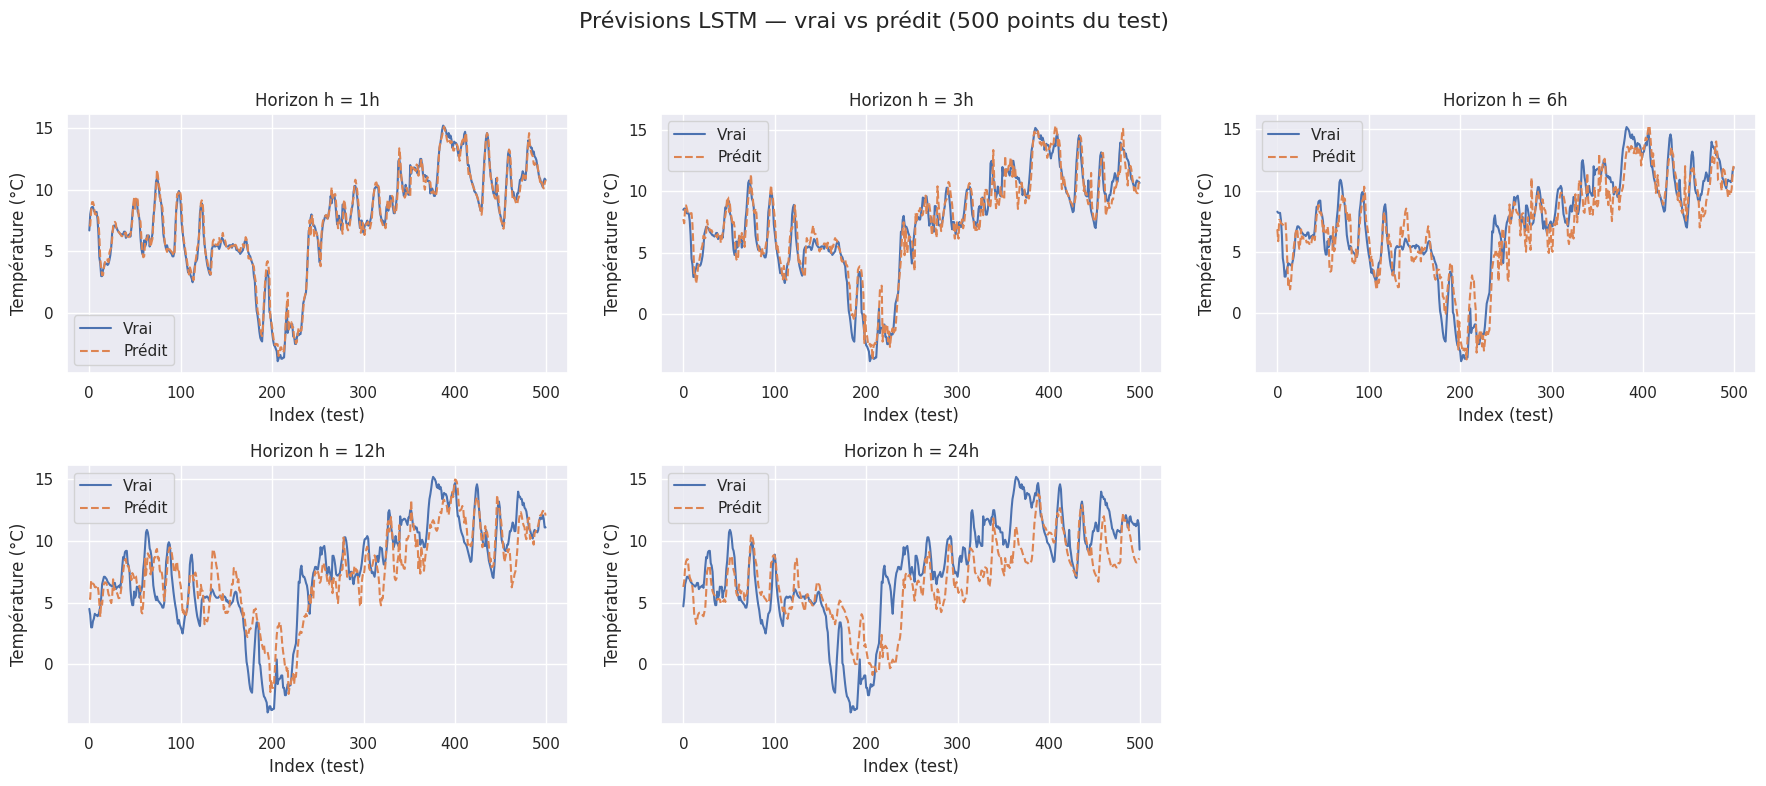

In [24]:
# Horizons à afficher
H_TO_PLOT = [1, 3, 6, 12, 24]

n_plot = 500   # nombre de points affichés
start = 0      # point de départ dans le test

n_cols = 3
n_rows = math.ceil(len(H_TO_PLOT) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.flatten()  # pour itérer facilement

for i, h in enumerate(H_TO_PLOT):
    ax = axes[i]

    if h not in saved_preds:
        ax.set_title(f"h = {h}h (non disponible)")
        ax.axis("off")
        continue

    y_true_c, y_hat_c = saved_preds[h]

    ax.plot(y_true_c[start:start+n_plot], label="Vrai")
    ax.plot(y_hat_c[start:start+n_plot], linestyle="--", label="Prédit")
    ax.set_title(f"Horizon h = {h}h")
    ax.set_xlabel("Index (test)")
    ax.set_ylabel("Température (°C)")
    ax.grid(True)
    ax.legend()

# Désactiver les axes vides (si nb de graphes < n_rows*n_cols)
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.suptitle(f"Prévisions LSTM — vrai vs prédit ({n_plot} points du test)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### Interprétation 

Les figures ci-dessus comparent, sur le **jeu de test**, les valeurs réelles de la température et les prédictions du modèle **LSTM** pour différents horizons de prévision :

$$
h \in \{1, 3, 6, 12, 24\} \text{ heures}
$$

Pour chaque horizon, les courbes sont tracées sur les **500 premiers échantillons** du jeu de test.

- L’axe des abscisses correspond à l’**indice des échantillons** dans le jeu de test.
- L’axe des ordonnées représente la **température en degrés Celsius**.


### Analyse qualitative par horizon

#### Horizons courts — \( h = 1 \) h, \( h = 3 \) h

- Les prédictions suivent très étroitement la dynamique réelle.
- Les cycles diurnes et les variations rapides sont bien capturés.
- La tâche est fortement dominée par la **persistance temporelle à court terme**.

Ces résultats expliquent les **faibles erreurs MAE et RMSE** observées pour les petits horizons.


#### Horizons intermédiaires — \( h = 6 \) h, \( h = 12 \) h

- Les prédictions restent qualitativement cohérentes.
- Un **léger lissage** apparaît : pics et creux sont moins marqués.
- Un **déphasage temporel** commence à être visible sur certaines transitions rapides.

Le modèle capture encore la dynamique globale, mais avec une **précision réduite**.


#### Horizon long — \( h = 24 \) h

- Les tendances générales sont correctement suivies.
- Les amplitudes sont atténuées et certains extrêmes sont sous-estimés.
- La prédiction repose davantage sur des **structures saisonnières moyennes** que sur la variabilité fine.

Ce comportement est typique d’un **LSTM confronté à un horizon long** sans information future explicite.


### Conclusion 

Ces visualisations confirment que :

- le LSTM est **très performant à court terme** (\( h \leq 3 \) h),
- il conserve une capacité prédictive **raisonnable jusqu’à 24 h**,
- l’augmentation de l’erreur avec l’horizon est **structurelle** et non due à un défaut d’apprentissage.



# 3. Améliorations 

Dans cette section, nous visons deux objectifs complémentaires :

1) **Améliorer les performances** à horizon court/moyen (ex : 1h → 24h), en agissant sur :
   - la longueur de fenêtre passée (*lookback*),
   - l’architecture du réseau (capacité + régularisation),
   - la stratégie d’entraînement (EarlyStopping, réduction du LR).

2) **Étendre l’horizon de prévision** jusqu’à **1 semaine (168h)**, tout en gardant une comparaison équitable :
   - mêmes jeux train/val/test,
   - normalisation fit sur train uniquement,
   - métriques et interprétation en **°C** (via inverse transform).

## Horizons testés et choix du lookback

Nous considérons une grille d’horizons couvrant le court, moyen et long terme :

- court : 1h, 3h, 6h
- moyen : 12h, 24h
- long : 72h (3 jours), 168h (1 semaine)

Pour éviter un modèle “myope”, le **lookback** (fenêtre passée) doit augmenter avec l’horizon.
Nous utilisons une règle simple : `lookback(h) = max(48, 2h)` plafonnée raisonnablement pour éviter des séquences trop longues.

Ce choix permet :
- d’intégrer des cycles jour/nuit (≥ 48h),
- d’ajouter de la mémoire quand on vise des horizons longs (ex : 1 semaine).


In [70]:
# Paramètres de l'expérience
HORIZONS = [12, 24, 72, 168] 
EPOCHS_MAX = 20 #changée de 30 à 20 pour raisons de complexité 
BATCH_SIZE = 512 #changée de 256 à 512 pour raisons de complexité 
PATIENCE = 5
SEED = 0

def lookback_for_h(h, min_lb=48, max_lb=240):
    """
    Règle simple : lookback = max(48, 2*h), avec un plafond max_lb
    - min_lb=48h : capter au moins 2 jours
    - max_lb=336h : 2 semaines (évite séquences énormes)
    """
    return int(min(max_lb, max(min_lb, 2*h)))

LOOKBACK_BY_H = {h: lookback_for_h(h) for h in HORIZONS}
LOOKBACK_BY_H

{12: 48, 24: 48, 72: 144, 168: 240}

## Modèles comparés : baseline vs amélioré

Nous comparons deux architectures :

### A- Baseline LSTM
Un LSTM simple (capacité modérée) servant de référence.

### B- LSTM amélioré (stacked + régularisation)
Deux couches LSTM empilées pour capturer des dynamiques plus longues, avec :
- Dropout pour réduire l’overfitting,
- un Dense intermédiaire léger,
- ReduceLROnPlateau pour stabiliser l’optimisation sur horizons longs.

L’objectif est d’améliorer la généralisation tout en gardant un modèle interprétable et stable.


In [71]:
# Builder du modèles + callbacks
def build_model_improved(lookback, n_features, seed=0):
    tf.keras.backend.clear_session()
    tf.random.set_seed(seed)

    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(lookback, n_features)),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(32, activation="relu"),
        Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
                  loss="mse")
    return model

def get_callbacks():
    early_stop = EarlyStopping(
        monitor="val_loss",
        patience=PATIENCE,
        restore_best_weights=True
    )
    reduce_lr = ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=3,
        min_lr=1e-5,
        verbose=0
    )
    return [early_stop, reduce_lr]


In [72]:
results = []
saved_preds = {}  # (model_name, h) -> (y_true_c, y_pred_c)
saved_hist  = {}  # (model_name, h) -> history

MODELS = {
    "improved": build_model_improved
}

for h in HORIZONS:
    lb = LOOKBACK_BY_H[h]

    # Séquences
    X_train_h, y_train_h = make_sequences(df_train, FEATURES, TARGET, lb, h)
    X_val_h,   y_val_h   = make_sequences(df_val,   FEATURES, TARGET, lb, h)
    X_test_h,  y_test_h  = make_sequences(df_test,  FEATURES, TARGET, lb, h)

    n_features = X_train_h.shape[-1]

    for model_name, builder in MODELS.items():
        model = builder(lb, n_features, seed=SEED)

        history = model.fit(
            X_train_h, y_train_h,
            validation_data=(X_val_h, y_val_h),
            epochs=EPOCHS_MAX,
            batch_size=BATCH_SIZE,
            callbacks=get_callbacks(),
            verbose=0
        )

        # Évaluation en °C
        mae_c, rmse_c, y_true_c, y_pred_c = eval_model_celsius(
            model=model,
            X_test=X_test_h,
            y_test=y_test_h,
            scaler=scaler,
            features_cont=FEATURES_CONT,
            target_name=TARGET
        )

        results.append({
            "model": model_name,
            "horizon_h": h,
            "lookback": lb,
            "MAE_test_C": float(mae_c),
            "RMSE_test_C": float(rmse_c),
            "epochs_run": len(history.history["loss"]),
            "best_val_loss": float(np.min(history.history["val_loss"]))
        })

        saved_preds[(model_name, h)] = (y_true_c, y_pred_c)
        saved_hist[(model_name, h)]  = history

df_res = pd.DataFrame(results).sort_values(["model","horizon_h"]).reset_index(drop=True)
df_res

,model,horizon_h,lookback,MAE_test_C,RMSE_test_C,epochs_run,best_val_loss
0,improved,12,48,1.766041,2.250886,11,0.102682
1,improved,24,48,2.075218,2.639260,13,0.138230
2,improved,72,144,2.718045,3.470081,12,0.255223
3,improved,168,240,2.957769,3.755070,7,0.293352


## Courbe “erreur vs horizon” (baseline vs improved)

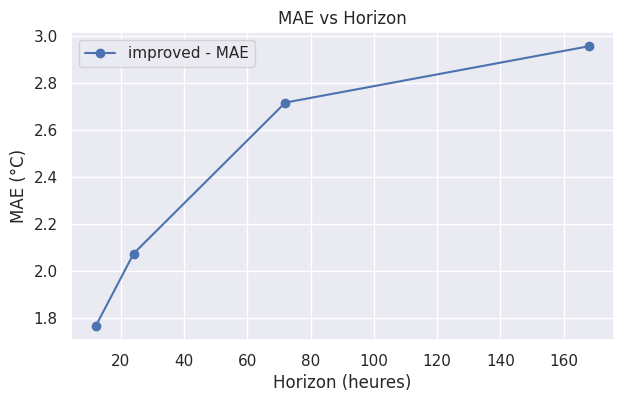

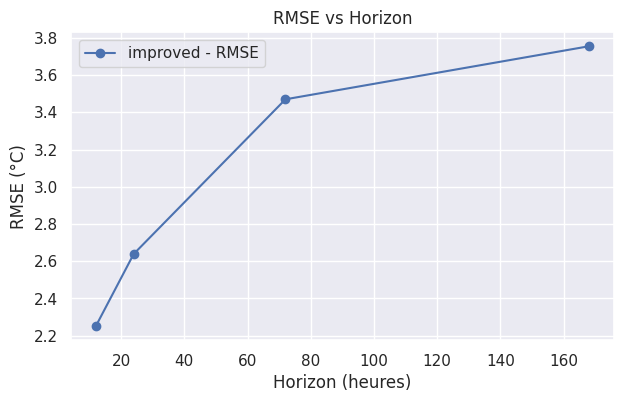

In [73]:
plt.figure(figsize=(7,4))
for model_name in df_res["model"].unique():
    sub = df_res[df_res["model"] == model_name]
    plt.plot(sub["horizon_h"], sub["MAE_test_C"], marker="o", label=f"{model_name} - MAE")
plt.xlabel("Horizon (heures)")
plt.ylabel("MAE (°C)")
plt.title("MAE vs Horizon")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(7,4))
for model_name in df_res["model"].unique():
    sub = df_res[df_res["model"] == model_name]
    plt.plot(sub["horizon_h"], sub["RMSE_test_C"], marker="o", label=f"{model_name} - RMSE")
plt.xlabel("Horizon (heures)")
plt.ylabel("RMSE (°C)")
plt.title("RMSE vs Horizon")
plt.legend()
plt.grid(True)
plt.show()

## Plots “Vrai vs Prédit” sur horizons clés (1h, 24h, 168h)

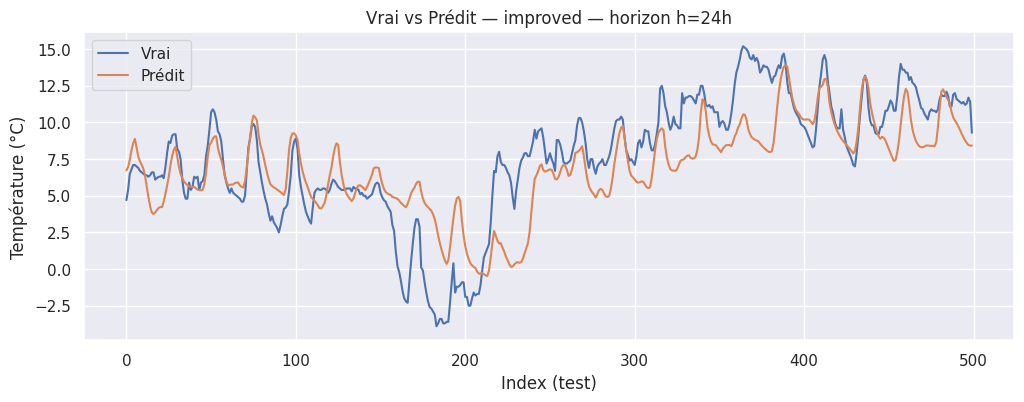

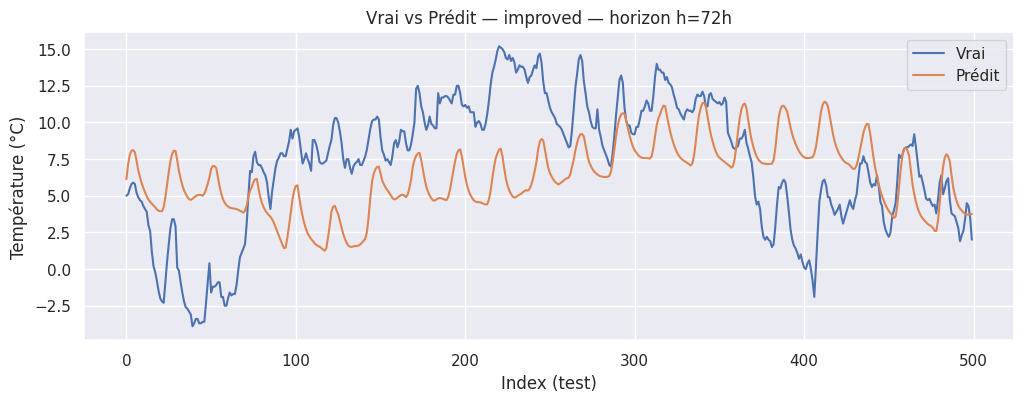

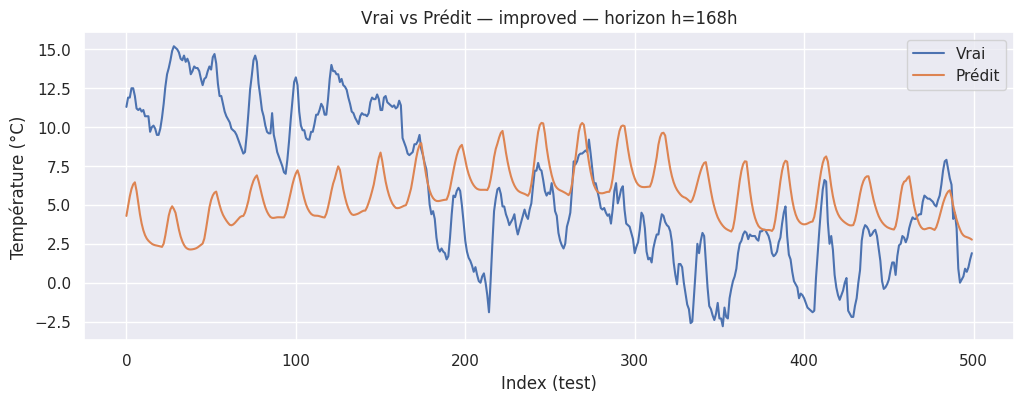

In [75]:
def plot_true_vs_pred(saved_preds, model_name, h, n_plot=500):
    y_true_c, y_pred_c = saved_preds[(model_name, h)]
    plt.figure(figsize=(12,4))
    plt.plot(y_true_c[:n_plot], label="Vrai")
    plt.plot(y_pred_c[:n_plot], label="Prédit")
    plt.title(f"Vrai vs Prédit — {model_name} — horizon h={h}h")
    plt.xlabel("Index (test)")
    plt.ylabel("Température (°C)")
    plt.legend()
    plt.grid(True)
    plt.show()

for model_name in ["improved"]:
    for h in [1, 24, 72, 168]:
        if (model_name, h) in saved_preds:
            plot_true_vs_pred(saved_preds, model_name, h, n_plot=500)

Les résultats montrent une dégradation progressive des performances lorsque l’horizon de prévision augmente.
À 24h, le modèle LSTM capture efficacement la dynamique journalière et la tendance thermique, tandis qu’à 72h il conserve la structure saisonnière mais perd la capacité à suivre les variations de régime.
À 168h, la prédiction converge vers une oscillation moyenne reflétant la saisonnalité journalière, traduisant la limite intrinsèque de la prévision météorologique déterministe à long terme en l’absence d’informations exogènes futures.

In [89]:
import numpy as np

TARGET = "temperature_2m"

# Assure ordre chrono
df.index = pd.to_datetime(df.index)
df = df.sort_index()

# ---------- Features calendrier (saisonnalité) ----------
dt = df.index
df["hour_sin"] = np.sin(2*np.pi*dt.hour/24)
df["hour_cos"] = np.cos(2*np.pi*dt.hour/24)

df["dow_sin"]  = np.sin(2*np.pi*dt.dayofweek/7)
df["dow_cos"]  = np.cos(2*np.pi*dt.dayofweek/7)

# ---------- Lags & stats (clé pour 72h / 168h) ----------
df["temp_lag24"]  = df[TARGET].shift(24)
df["temp_lag72"]  = df[TARGET].shift(72)
df["temp_lag168"] = df[TARGET].shift(168)

df["temp_roll24"]  = df[TARGET].rolling(24).mean()
df["temp_roll72"]  = df[TARGET].rolling(72).mean()
df["temp_roll168"] = df[TARGET].rolling(168).mean()

# Drop NA créés par shift/rolling (important sinon scaling casse)
df = df.dropna()

In [90]:
df["is_sunny"] = (df["sunshine_duration"] > 0).astype(int)

FEATURES_CONT = [
    "temperature_2m",
    "dew_point_2m",
    "soil_temperature_0_to_7cm",
    "soil_moisture_0_to_7cm",

    # long-horizon helpers
    "hour_sin","hour_cos","dow_sin","dow_cos",
    "temp_lag24","temp_lag72","temp_lag168",
    "temp_roll24","temp_roll72","temp_roll168",
]

FEATURES_BIN = ["is_day", "is_sunny"]
FEATURES = FEATURES_CONT + FEATURES_BIN


In [91]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df_train[FEATURES_CONT])

df_train[FEATURES_CONT] = scaler.transform(df_train[FEATURES_CONT])
df_val[FEATURES_CONT]   = scaler.transform(df_val[FEATURES_CONT])
df_test[FEATURES_CONT]  = scaler.transform(df_test[FEATURES_CONT])

print("len(FEATURES_CONT) =", len(FEATURES_CONT))
print("scaler.n_features_in_ =", scaler.n_features_in_)


len(FEATURES_CONT) = 14
scaler.n_features_in_ = 14


In [92]:
def make_sequences(df_in, features, target, lookback, horizon=1, history_window=None):
    # Fenêtre glissante pour accélérer (garde assez de points pour construire X,y)
    if history_window is not None:
        need = history_window + lookback + horizon + 1
        df_in = df_in.iloc[-need:]

    X, y = [], []
    values = df_in[features].values
    target_values = df_in[target].values

    for i in range(lookback, len(df_in) - horizon + 1):
        X.append(values[i - lookback:i])
        y.append(target_values[i + horizon - 1])

    return np.array(X), np.array(y)


In [93]:
HISTORY_WINDOW = 2000

X_train_h, y_train_h = make_sequences(df_train, FEATURES, TARGET, lb, h, history_window=HISTORY_WINDOW)
X_val_h,   y_val_h   = make_sequences(df_val,   FEATURES, TARGET, lb, h)
X_test_h,  y_test_h  = make_sequences(df_test,  FEATURES, TARGET, lb, h)


In [94]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D
import tensorflow as tf

def build_model_longh(lookback, n_features, seed=0):
    tf.keras.backend.clear_session()
    tf.random.set_seed(seed)

    model = Sequential([
        Conv1D(32, kernel_size=3, padding="causal", activation="relu",
               input_shape=(lookback, n_features)),
        LSTM(32),
        Dropout(0.15),
        Dense(32, activation="relu"),
        Dense(1)
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1.0),
        loss="mse"
    )
    return model


In [95]:
MODELS = {
    "longh_fast": build_model_longh
}


In [96]:
from tensorflow.keras.callbacks import EarlyStopping

HORIZONS = [72, 168]
LOOKBACK_BY_H = {72: 72, 168: 168}

HISTORY_WINDOW = 2000
EPOCHS = 25
BATCH = 64

results = {}
saved_preds = {}
saved_hist = {}
models_trained = {}

for h in HORIZONS:
    lb = LOOKBACK_BY_H.get(h, 72)  # fallback safe

    print(f"\n==================== h={h}h | lookback={lb} ====================")

    # 1) Sequences (train accéléré)
    X_train_h, y_train_h = make_sequences(df_train, FEATURES, TARGET, lb, h, history_window=HISTORY_WINDOW)
    X_val_h,   y_val_h   = make_sequences(df_val,   FEATURES, TARGET, lb, h)
    X_test_h,  y_test_h  = make_sequences(df_test,  FEATURES, TARGET, lb, h)

    print("Shapes:", X_train_h.shape, X_val_h.shape, X_test_h.shape)

    # 2) Model
    model = build_model_longh(lb, X_train_h.shape[-1], seed=0)

    # 3) EarlyStopping
    es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

    # 4) Train
    hist = model.fit(
        X_train_h, y_train_h,
        validation_data=(X_val_h, y_val_h),
        epochs=EPOCHS,
        batch_size=BATCH,
        callbacks=[es],
        verbose=1
    )

    # 5) Eval en °C (ta fonction)
    mae_c, rmse_c, y_test_c, y_pred_c = eval_model_celsius(
        model, X_test_h, y_test_h,
        scaler=scaler,
        features_cont=FEATURES_CONT,
        target_name=TARGET
    )

    # 6) Save
    results[h] = {"MAE_test_C": float(mae_c), "RMSE_test_C": float(rmse_c)}
    saved_preds[h] = (y_test_c, y_pred_c)
    saved_hist[h] = hist
    models_trained[h] = model

    print(f"h={h} | MAE={mae_c:.3f}°C | RMSE={rmse_c:.3f}°C")

# Résumé
import pandas as pd
df_res = pd.DataFrame([
    {"horizon_h": h, **results[h]} for h in HORIZONS
]).sort_values("horizon_h").reset_index(drop=True)

display(df_res)



==================== h=72h | lookback=72 ====================
Shapes: (2002, 72, 16) (33125, 72, 16) (33125, 72, 16)
Epoch 1/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 261ms/step - loss: 0.4790 - val_loss: 0.6100
Epoch 2/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 255ms/step - loss: 0.2796 - val_loss: 0.4765
Epoch 3/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 257ms/step - loss: 0.2247 - val_loss: 0.3803
Epoch 4/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 253ms/step - loss: 0.1910 - val_loss: 0.3639
Epoch 5/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 265ms/step - loss: 0.1682 - val_loss: 0.3998
Epoch 6/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 252ms/step - loss: 0.1626 - val_loss: 0.5260
Epoch 7/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 244ms/step - loss: 0.1369 - val_loss: 0.7023
Epoch 8/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 250ms/step - loss: 0.1459 - val_loss: 0.6724
Epoch 9/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 257ms/step - loss: 0.1182 - val_loss: 0.7707
h=72 | MAE=0.462°C | RMSE=0.581°C

==================== h=168h | lookback=168 ====================
Shapes: 

,horizon_h,MAE_test_C,RMSE_test_C
0,72,0.462164,0.581011
1,168,0.494165,0.629931


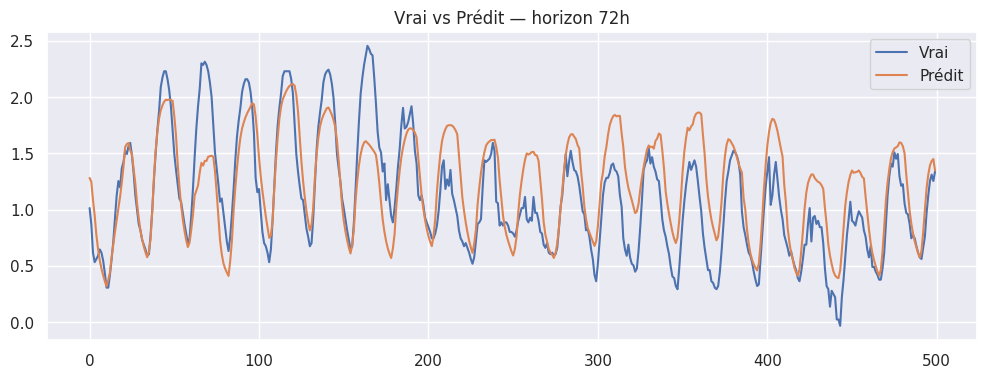

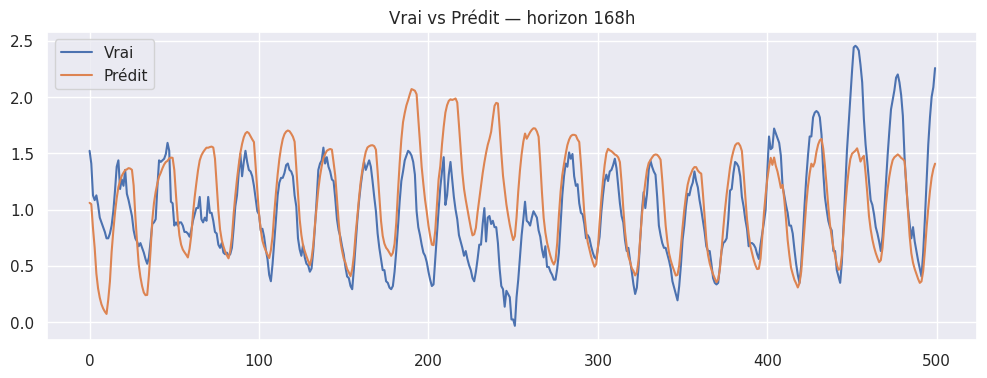

In [97]:
import matplotlib.pyplot as plt

N_PLOT = 500
for h in HORIZONS:
    y_test_c, y_pred_c = saved_preds[h]   # <-- déjà en °C

    plt.figure(figsize=(12,4))
    plt.plot(y_test_c[:N_PLOT], label="Vrai")
    plt.plot(y_pred_c[:N_PLOT], label="Prédit")
    plt.title(f"Vrai vs Prédit — horizon {h}h")
    plt.legend()
    plt.grid(True)
    plt.show()



==================== Rolling h=1 (t+1) | lookback=12 ====================
Shapes: (2002, 12, 16) (33256, 12, 16) (33256, 12, 16)
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - loss: 0.5930 - val_loss: 0.5457
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.2664 - val_loss: 0.3743
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.1515 - val_loss: 0.2943
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0996 - val_loss: 0.2558
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0835 - val_loss: 0.2248
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0725 - val_loss: 0.2133
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.0655 - val_loss: 0.2058
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0612 - val_loss: 0.1852
Epoch 9/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0544 - val_loss: 0.1840
Epoch 10/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0507 - val_loss: 0.1818
Epoch 11/

,horizon_h,MAE_test_C,RMSE_test_C
0,1,0.298316,0.408425


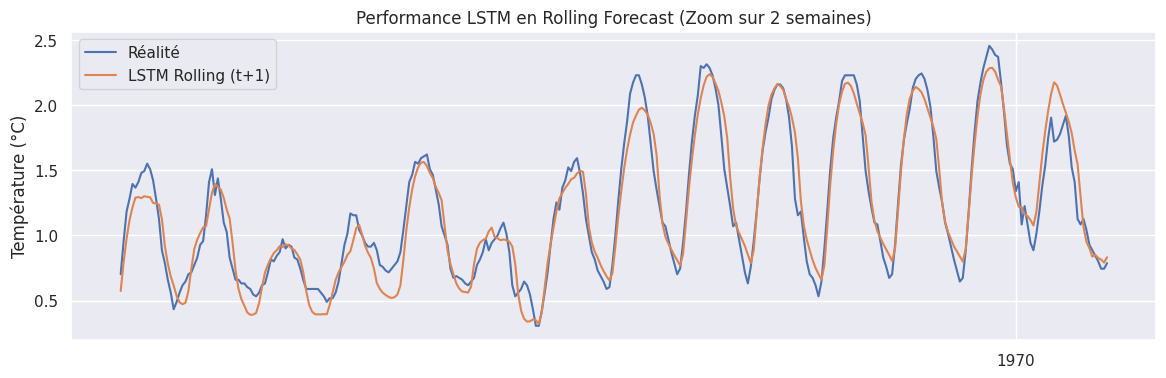

In [107]:
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import matplotlib.pyplot as plt

# Rolling one-step ahead
HORIZONS = [1]
LOOKBACK_BY_H = {1: 12}     # ou 48/72/168 selon ton choix
HISTORY_WINDOW = 2000
EPOCHS = 20
BATCH = 128

results = {}
saved_preds = {}
saved_hist = {}
models_trained = {}

for h in HORIZONS:
    lb = LOOKBACK_BY_H.get(h, 12)

    print(f"\n==================== Rolling h={h} (t+1) | lookback={lb} ====================")

    X_train_h, y_train_h = make_sequences(df_train, FEATURES, TARGET, lb, h, history_window=HISTORY_WINDOW)
    X_val_h,   y_val_h   = make_sequences(df_val,   FEATURES, TARGET, lb, h)
    X_test_h,  y_test_h  = make_sequences(df_test,  FEATURES, TARGET, lb, h)

    print("Shapes:", X_train_h.shape, X_val_h.shape, X_test_h.shape)

    model = build_model_longh(lb, X_train_h.shape[-1], seed=0)
    es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

    hist = model.fit(
        X_train_h, y_train_h,
        validation_data=(X_val_h, y_val_h),
        epochs=EPOCHS,
        batch_size=BATCH,
        callbacks=[es],
        verbose=1
    )

    mae_c, rmse_c, y_test_c, y_pred_c = eval_model_celsius(
        model, X_test_h, y_test_h,
        scaler=scaler,
        features_cont=FEATURES_CONT,
        target_name=TARGET
    )

    results[h] = {"MAE_test_C": float(mae_c), "RMSE_test_C": float(rmse_c)}
    saved_preds[h] = (y_test_c, y_pred_c, lb)
    saved_hist[h] = hist
    models_trained[h] = model

    print(f"Rolling t+1 | MAE={mae_c:.3f}°C | RMSE={rmse_c:.3f}°C")

display(pd.DataFrame([{"horizon_h": h, **results[h]} for h in HORIZONS]))

# Plot sur 2 semaines (comme ton ami)
y_test_c, y_pred_c, lb = saved_preds[1]
# index datetime propre
idx = pd.to_datetime(df_test.index)

# alignement avec y_test_c (qui commence après lb)
t_idx = idx[lb: lb + len(y_test_c)]
N = 14*24  # 2 semaines
plt.figure(figsize=(14,4))
plt.plot(t_idx[:N], y_test_c[:N], label="Réalité")
plt.plot(t_idx[:N], y_pred_c[:N], label="LSTM Rolling (t+1)")
plt.title("Performance LSTM en Rolling Forecast (Zoom sur 2 semaines)")
plt.ylabel("Température (°C)")
plt.legend()
plt.grid(True)
plt.show()
